# PRISMO vs MOFA on CLL Data

## PRISMO

In [1]:
# # run with "prismo" kernel
# from prismo import (
#     PRISMO,
#     DataOptions,
#     ModelOptions,
#     TrainingOptions,
# )
# from data_loader import load_cll

# data = load_cll()

# for seed in range(10):
#     prismo_model = PRISMO(
#         data,
#         DataOptions(
#             plot_data_overview=False,
#         ),
#         ModelOptions(
#             n_factors=10,
#             weight_prior="Horseshoe",
#             factor_prior="Normal",
#             likelihoods="Normal",
#         ),
#         TrainingOptions(
#             device="cuda:0",
#             max_epochs=10000,
#             lr=0.05,
#             early_stopper_patience=1000,
#             print_every=500,
#             save_path=f"models_hs/prismo_{seed}",
#             seed=seed,
#         )
#     )

## MOFA

In [2]:
# # run with "muon" kernel
# import muon as mu
# import pandas as pd
# from data_loader import load_cll

# data = load_cll()
# mdata = mu.MuData(data)
# obs = pd.read_csv("data/cll_metadata.csv", index_col="Sample")
# mdata.obs = mdata.obs.join(obs)

# mu.tl.mofa(mdata, use_obs='union',
#     n_factors=10, convergence_mode='medium',
#     outfile="mofa.h5"
#     )

## Comparison

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_cll

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [45]:
view_names = {
    "mrna" : "mRNA",
    "methylation" : "Methylation",
    "mutations" : "Mutations",
    "drugs" : "Drugs",
}

In [46]:
mofa_model = mofa.mofa_model("mofa.h5")
z_mofa = pd.DataFrame(
    mofa_model.factors['group1'][:].T,
    index=mofa_model.samples['group1'],
    columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)],
) / 10

w_mofa = {}
for view in mofa_model.views:
    w_mofa[view_names[view]] = pd.DataFrame(
        mofa_model.weights[view][:].T,
        index=mofa_model.features[view],
        columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)]
    ) * 10

r2_mofa = mofa_model.get_variance_explained().drop(columns="Group")
r2_mofa.replace({"View" : view_names}, inplace=True)
r2_mofa.replace({"Factor": {f"Factor{i}": f"{i}" for i in range(1, mofa_model.nfactors + 1)}}, inplace=True)
r2_mofa["Factor"] = pd.Categorical(r2_mofa["Factor"], categories=[f"{i+1}" for i in range(mofa_model.nfactors)], ordered=True)
r2_mofa["R2"] = r2_mofa["R2"] / 100

In [47]:
z_prismo = {}
w_prismo = {}
r2_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models_hs/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = {}
    for view in view_names.keys():
        w_prismo[seed][view_names[view]] = prismo_model[seed].get_weights()[view].T
    r2_prismo[seed] = prismo_model[seed].get_r2()['group_1'].reset_index(names="Factor").melt(id_vars="Factor", var_name="View", value_name="R2")
    r2_prismo[seed].replace({"View" : view_names}, inplace=True)
    r2_prismo[seed].replace({"Factor": {f"Factor {i}": f"{i}" for i in range(1, mofa_model.nfactors + 1)}}, inplace=True)
    r2_prismo[seed]["Factor"] = pd.Categorical(r2_prismo[seed]["Factor"], categories=[f"{i+1}" for i in range(prismo_model[seed].n_factors)], ordered=True)

### Factor matching based on correlation

In [48]:
for seed in range(10):
    z_mofa_inds, z_prismo_inds, z_signs = match(z_mofa, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed][view] = w_prismo[seed][view].iloc[:, z_prismo_inds]
        w_prismo[seed][view] = w_prismo[seed][view] * z_signs.reshape(1, -1)
        w_prismo[seed][view].columns = [f"Factor {i+1}" for i in range(w_prismo[seed][view].shape[1])]

    replace_dict = {f"{j+1}" : f"{i+1}" for i, j in enumerate(z_prismo_inds)}
    r2_prismo[seed].replace({"Factor" : replace_dict}, inplace=True)

### Correlation plots

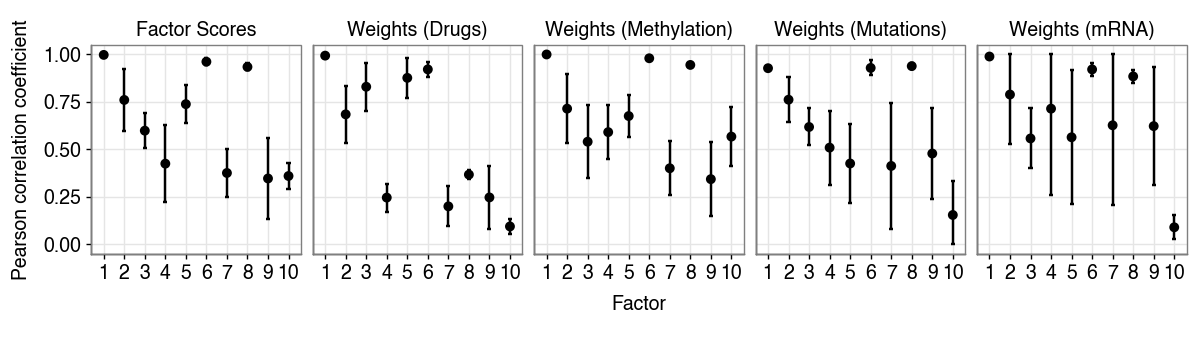

In [54]:
def plot_correlations(z_prismo, z_mofa, w_prismo, w_mofa, figure_size=(6., 1.7), errorbar_width=0.2):
    seeds = list(z_prismo.keys())
    views = list(w_prismo[seeds[0]].keys())
    n_factors = z_prismo[0].shape[1]

    df = []
    for seed in seeds:
        corr = []
        for i in range(n_factors):
            corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_mofa.iloc[:, i])[0])
        df.append(pd.DataFrame(corr, columns=["corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
        df[-1]["lv"] = "Factor Scores"

        for view in views:
            corr = []
            for i in range(n_factors):
                corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_mofa[view].iloc[:, i])[0].item())
            df.append(pd.DataFrame(corr, columns=[f"corr"]))
            df[-1]["seed"] = seed
            df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
            df[-1]["lv"] = f"Weights ({view})"

    df = pd.concat(df, axis=0)

    df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
    df["min"] = df["mean"] - df["std"]
    df["max"] = df["mean"] + df["std"]
    df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(n_factors)], ordered=True)
    df["min"] = np.clip(df["min"], a_min=0., a_max=1.)
    df["max"] = np.clip(df["max"], a_min=0., a_max=1.)

    return (
        ggplot(df, aes(x="factor", y="mean", group="lv"))
        + geom_point(size=1.)
        + geom_errorbar(aes(ymin="min", ymax="max"), width=errorbar_width)
        + facet_wrap("~lv", scales="fixed", ncol=5)
        + theme(
            figure_size=figure_size,
        )
        + labs(x="Factor", y="Pearson correlation coefficient")
        + ylim(0, 1)
    )

plot = plot_correlations(z_prismo, z_mofa, w_prismo, w_mofa)
fig = plot.draw()
fig.savefig("plots/correlations.pdf")
plot.show()

### Weights scatter plots

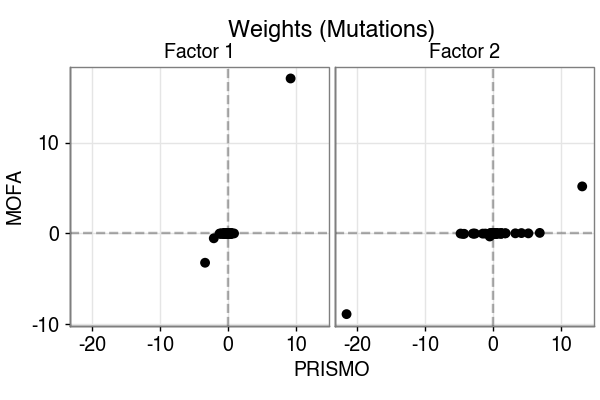

In [58]:
factors = ["Factor 1", "Factor 2"]
view = "Mutations"
seed = 0

df_list = []
for factor in factors:
    df_temp = pd.DataFrame({
        "weight_prismo": w_prismo[seed][view][factor],
        "weight_mofa": w_mofa[view][factor],
        "factor": factor
    })
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

plot = (
    ggplot(df, aes(x="weight_prismo", y="weight_mofa"))
    + geom_point(size=1.)
    + labs(x="PRISMO", y="MOFA", title=f"Weights ({view})")
    + theme(figure_size=(3, 2), plot_title=element_text(ha='center'))
    + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
    + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    + facet_wrap("~factor", scales="fixed")
)

fig = plot.draw()
fig.savefig(f"plots/mutations_weights.pdf")
plot.show()

### Variance explained plots

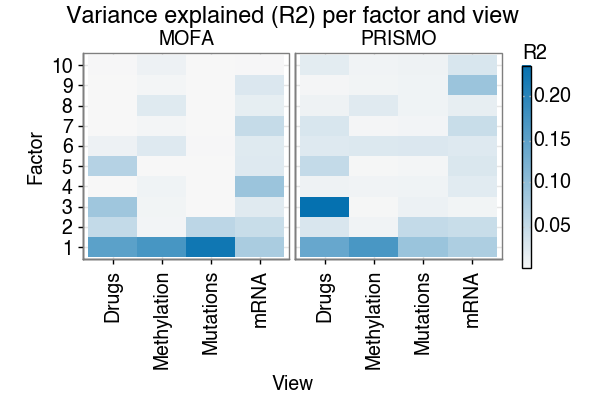

In [56]:
seed = 0

r2_prismo[seed]["model"] = "PRISMO"
r2_mofa["model"] = "MOFA"
df = pd.concat([r2_prismo[seed], r2_mofa], ignore_index=True)
plot = (
    ggplot(df, aes(x="View", y="Factor", fill="R2", group="model"))
    + geom_tile()
    + scale_fill_gradient(low="#f7f7f7", high="#0571b0", name="R2")
    + labs(x="View", y="Factor", title="Variance explained (R2) per factor and view", fill="R2")
    + theme(axis_text_x=element_text(rotation=90), figure_size=(3, 2), legend_key_width=3.)
    + facet_wrap("~model")
)

fig = plot.draw()
fig.savefig(f"plots/variance_explained.pdf")
plot.show()

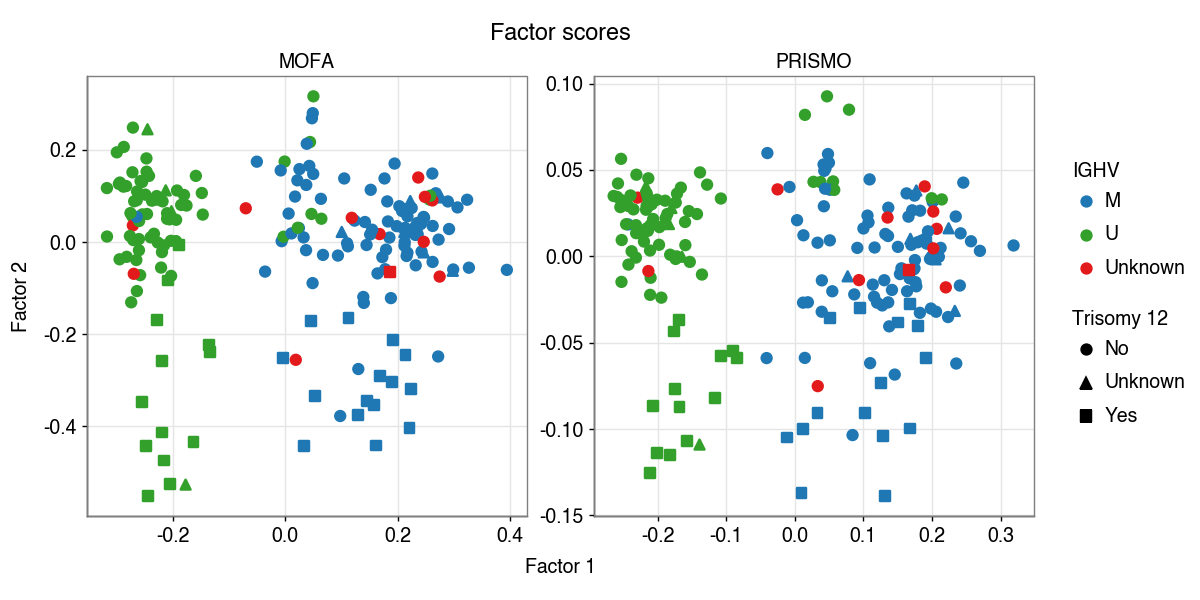

In [59]:
seed = 0

data = load_cll()

metadata = pd.read_csv("data/cll_metadata.csv", index_col="Sample")
metadata = pd.merge(pd.DataFrame(index=prismo_model[seed].sample_names["group_1"]), metadata, left_index=True, right_index=True)
metadata["trisomy12"] = data['mutations'].to_df()["m_trisomy12"]

df_prismo = metadata[["IGHV", "trisomy12"]].astype("str")
df_prismo["Factor 1"] = z_prismo[seed]["Factor 1"]
df_prismo["Factor 2"] = z_prismo[seed]["Factor 2"]
df_prismo["Model"] = "PRISMO"

df_mofa = metadata[["IGHV", "trisomy12"]].astype("str")
df_mofa["Factor 1"] = z_mofa["Factor 1"]
df_mofa["Factor 2"] = z_mofa["Factor 2"]
df_mofa["Model"] = "MOFA"

df = pd.concat([df_prismo, df_mofa], ignore_index=True)

df["trisomy12"] = df["trisomy12"].replace({"0.0" : "No", "1.0" : "Yes"})
df.replace({"nan" : "Unknown"}, inplace=True)

plot = (
    ggplot(df, aes(x="Factor 1", y="Factor 2", color="IGHV", shape="trisomy12", group="Model"))
    + geom_point(size=1.5)
    + labs(x="Factor 1", y="Factor 2", color="IGHV", shape="Trisomy 12", title="Factor scores")
    + theme(figure_size=(6, 3), legend_position="right")
    + facet_wrap("~Model", scales="free")
    + plotting_settings.discrete_scale_color
)

fig = plot.draw()
fig.savefig(f"plots/mutations_factors.pdf")
plot.show()